In [1]:
import numpy as np
from attacker import SGA
from classifier import SGC, GCN

import utils
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
adj, x, y = utils.load_npz('cora')
train_nodes, val_nodes, test_nodes = utils.train_val_test_split_tabular(y.shape[0], stratify=y, random_state=15)
degree = adj.sum(1).A1
num_classes = y.max() + 1

In [3]:
target = 0
retrain_iters = 5
budget = degree[target]

In [4]:
model = SGC(adj, x, y, seed=42)
model.train(train_nodes, val_nodes=val_nodes, verbose=False)
f1_micro, f1_macro = model.test(test_nodes)
print(f'【Test】f1 micro {f1_micro:.2%}, f1_macro {f1_macro:.2%}')

【Test】f1 micro 84.51%, f1_macro 82.70%


In [5]:
W, b = model.get_weight()
attacker = SGA(adj, x, y, W, b)
attacker.attack(target, budget, direct_attack=True)
edge = attacker.get_attack_edge()

In [6]:
def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    """Numpy version of Softmax activation function

    Parameters
    ----------
    x : np.ndarray
        Elements to softmax.
    axis : int, optional
        Axis or axes along which a softmax is performed, by default -1.

    Returns
    -------
    softmax_along_axis: np.ndarray
        An array with the same shape as `x`.
    """
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=axis, keepdims=True)

    
def evaluate(adj):
    classification_margins = []
    class_distrs = []
    for _ in range(retrain_iters):
        print("... {}/{} ".format(_+1, retrain_iters))
        model = SGC(adj, x, y, seed=None)
        model.train(train_nodes, val_nodes=val_nodes, verbose=False)
        logit = model.predict(target)
        logit = softmax(logit)
        class_distrs.append(logit)
        best_second_class_before = (logit - np.eye(num_classes)[y[target]]).argmax()
        margin = logit[y[target]] - logit[best_second_class_before]
        classification_margins.append(margin)
        model.close()
        
    class_distrs = np.array(class_distrs)
    return class_distrs

In [7]:
print("before attack")
class_distrs_clean = evaluate(adj)
print("after attack")
class_distrs_retrain = evaluate(utils.flip_adj(adj, edge))

before attack
... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 
after attack
... 1/5 
... 2/5 
... 3/5 
... 4/5 
... 5/5 


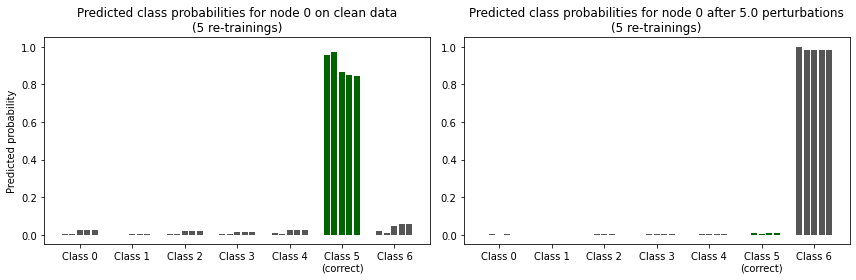

In [8]:
def make_xlabel(ix, correct):
    if ix == correct:
        return "Class {}\n(correct)".format(ix)
    return "Class {}".format(ix)


figure = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(class_distrs_clean.T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)

ax = plt.gca()
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
ax.set_xticks(center_ixs_clean)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} on clean data\n({retrain_iters} re-trainings)")

fig = plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(class_distrs_retrain.T):
    x_ixs = np.arange(len(block)) + ix*(len(block)+2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = '#555555'
    if ix == y[target]:
        color = 'darkgreen'
    plt.bar(x_ixs, block, color=color)


ax = plt.gca()
plt.ylim((-.05, 1.05))
ax.set_xticks(center_ixs_retrain)
ax.set_xticklabels([make_xlabel(k, y[target]) for k in range(num_classes)])
ax.set_title(f"Predicted class probabilities for node {target} after {budget} perturbations\n({retrain_iters} re-trainings)")
plt.tight_layout()
plt.show()